In [154]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import GridSearchCV,train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, cv, plot_importance

In [2]:
login = pd.read_json('/Users/Amin/Documents/GitHub/Springbord/Ultimate Challenge Case Study/logins.json')

### Part 1 ‐ Exploratory data analysis

In [3]:
login['login_count'] = 1
login = login.set_index(pd.to_datetime(login['login_time']))[['login_count']]

In [4]:
login15min = login.resample('15T').sum()

In [49]:
login.shape

(93142, 3)

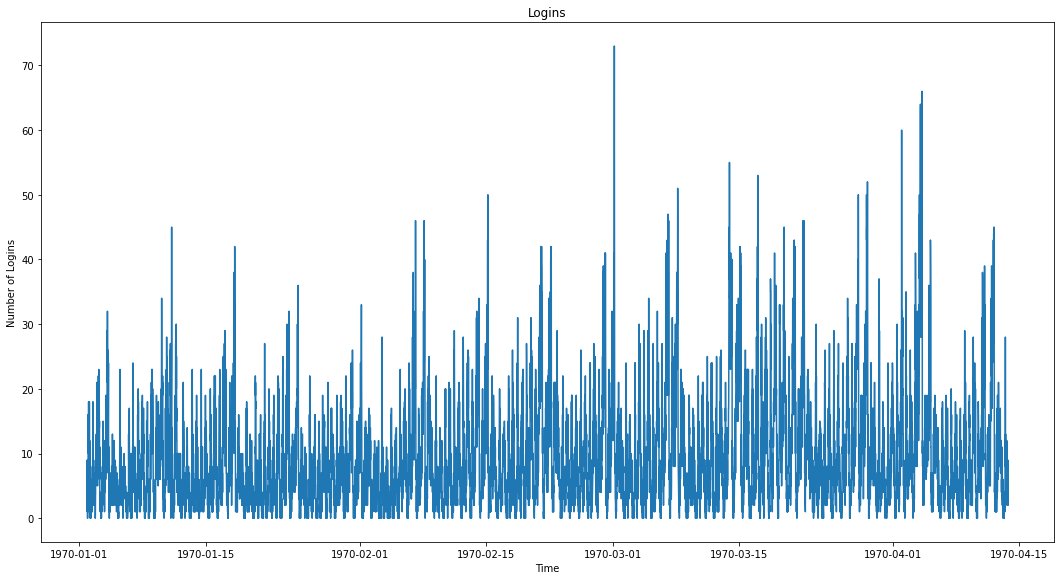

In [6]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')

plt.plot(login15min.index, login15min.login_count)

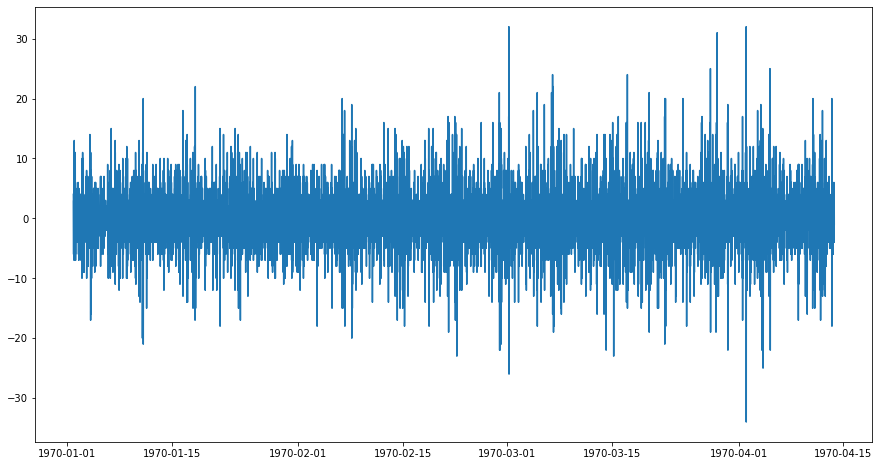

In [7]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(login15min.login_count.diff())

In [8]:
saturdays = login.resample('W-SAT').sum()
sundays = login.resample('W-SUN').sum()
bisdays = login.resample('B').sum()

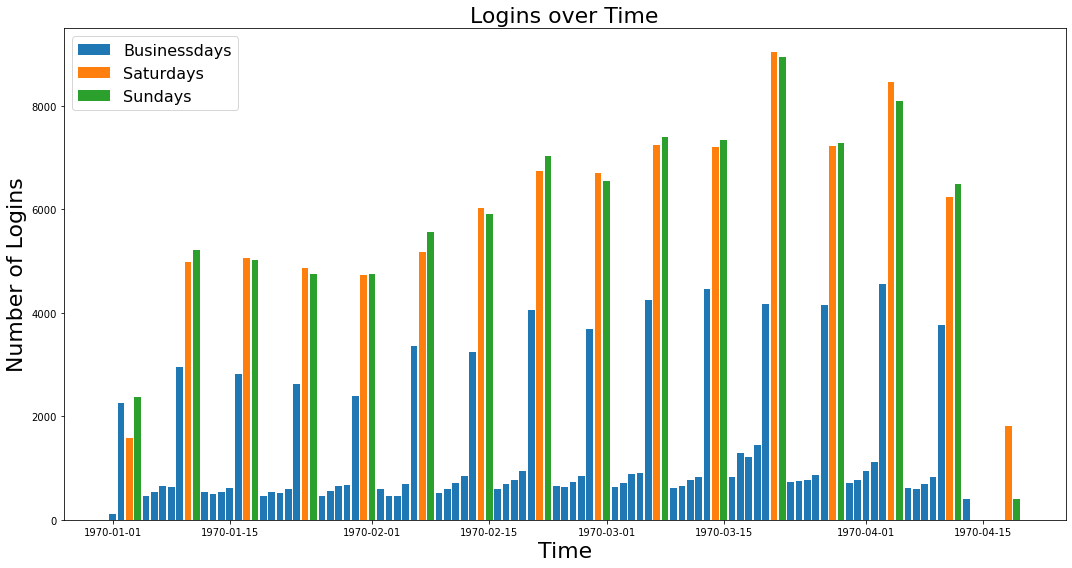

In [50]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)


plt.bar(bisdays.index, bisdays.login_count, label='Businessdays')
plt.bar(saturdays.index, saturdays.login_count, label='Saturdays')
plt.bar(sundays.index, sundays.login_count, label='Sundays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

Based on the graph above, __Weekends are busier than weekdays__. Among weekdays, __Friday__ is the busiest day.

In [10]:
login['day'] = login.index.strftime("%A")
login['hour'] = login.index.hour

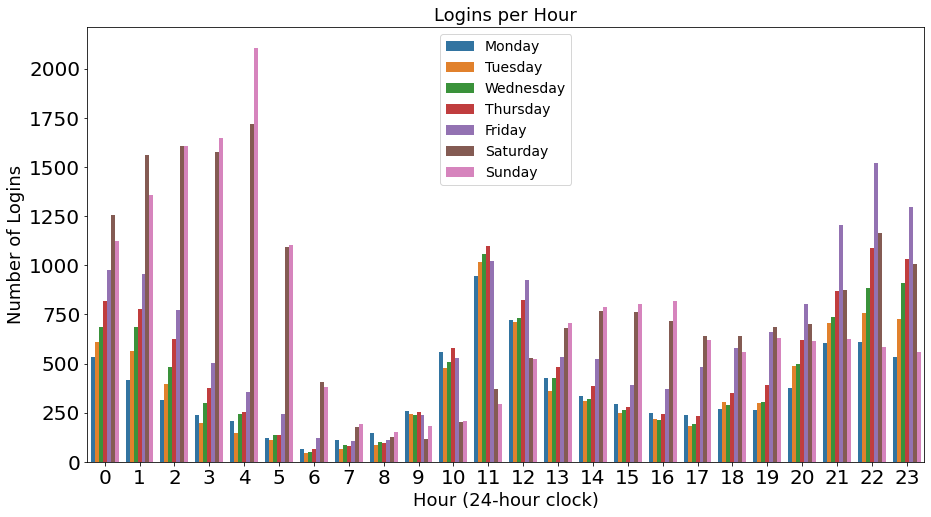

In [11]:
fig, ax = plt.subplots(figsize = (15,8))
_ = sns.countplot(hue='day',x='hour',data=login,hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

ax = plt.gca()
ax.set_title('Logins per Hour', fontsize = 18)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 18)
ax.set_ylabel('Number of Logins', fontsize = 18)

ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(loc='upper center', fontsize = 14)


* The busiest time of the day is between 1am to 5am on weekends.
* The businesday sees the serge between 11am and 12pm. This is the only time there is more login in compare to weekends.
* 6am to 9am has the lowest login for both weekends and businesday.



### Part 2 ‐ Experiment and metrics design

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

by using the data of how many time each driver cross the bridge,I will monitor the weekdays activity on the bridge. We know that weekends is busy anyway, but monitoring weekends can help us see the result of the reimbursement programm. The question is there an increase of cars entering the bridge from Gotham AND during the night is there an increase of cars entering the bridge from Metropolis. And I chose this because it is easy to measure with the data that we already have and we dont need any additional data.

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.

We can create a A/B test, divide the driver to two group, one participate in the reimbursement programm and one not. We can gathered the data for a month and then use the data for answering the two hypothesis.

* There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.
* There is no diffrence between the mean number of cars entering the bridge from Metropolitian during weekdas between 9 pm to 5 am, two weeks before reimbursemets were offered and the mean number of cars two weeks after reimbursements were offered.

If the p-value for both test was less than 0.05 I can reject the hypotesis and recommend the reimbursements programm.

If only one test has a p-values less than 0.05, I can suggest the reimbursements programm for the driver of that city and not the other city.

If both p-value was greater than 0.05, I suggest the autority to comes up with another programm.

### Part 3 ‐ Predictive modeling

In [12]:
data = pd.read_json('/Users/Amin/Documents/GitHub/Springbord/Ultimate Challenge Case Study/ultimate_data_challenge.json')

In [13]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
data.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are three columns with the NaN values. For the two average rating we fill the NaN with the average of the columns and for the phone we fill it with 'iPhone' because it is a more dominant valuein that columns.

In [15]:
data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean(),inplace=True)
data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean(),inplace=True)
data.phone.fillna('iPhone',inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

We have to create a columns to show if the user is active or not. The active user is user how had a trip in the last 30 days. So the last day that the data pull minus the 30 day would be the cut-off day.

In [18]:
last_day = data.last_trip_date.max()
cut_off = last_day - pd.Timedelta('30 days')
cut_off

Timestamp('2014-06-01 00:00:00')

In [19]:
data['active_user'] =  (data.last_trip_date > cut_off).astype('int')

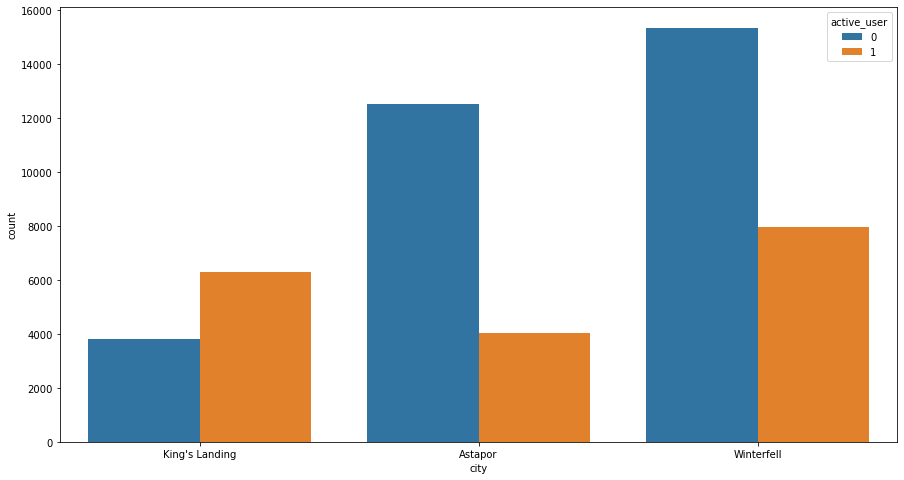

In [20]:
fig,ax = plt.subplots(figsize = (15,8))
_ = sns.countplot(x='city',data=data,hue='active_user')

Kings's Landing has more active user in compare to other cities.

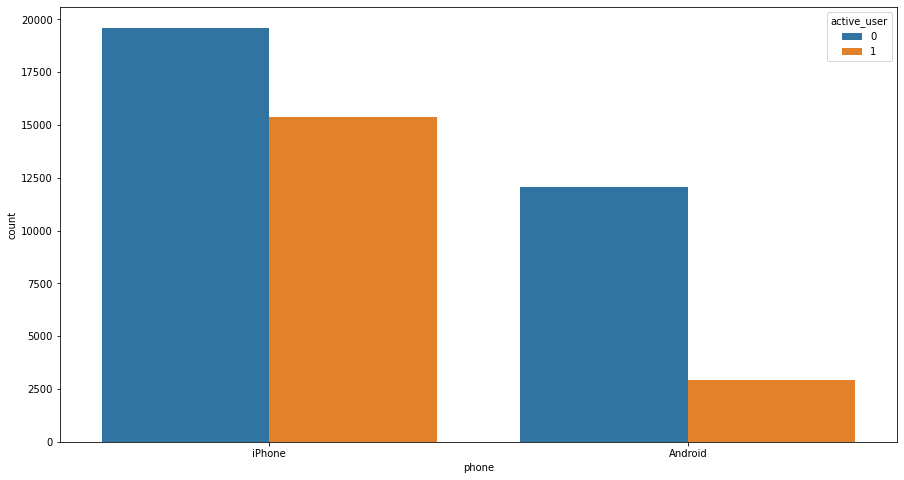

In [21]:
fig,ax = plt.subplots(figsize = (15,8))
_ = sns.countplot(x='phone',data=data,hue='active_user')

iPhone user are more number of active account in comapare to Android.

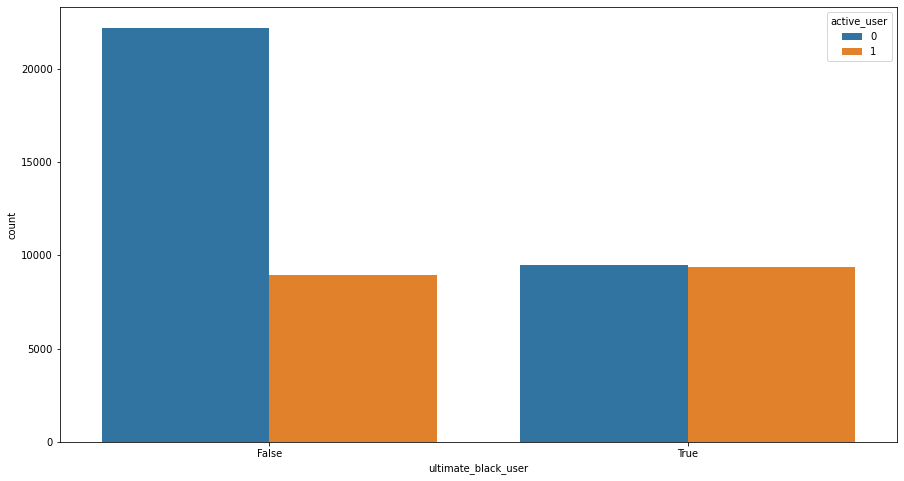

In [23]:
fig,ax = plt.subplots(figsize = (15,8))
_ = sns.countplot(x='ultimate_black_user',data=data,hue='active_user')

Half of the user that are part of the Ultimate Black account are actives. In contrast only one third of regular users are active.

In [22]:
data = pd.get_dummies(data, columns = ['city', 'phone'])

In [24]:
data

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,1,0,1,0,0,1
49996,1,2014-01-24,4.601559,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,0,1,0,0,0,1
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,0,0,0,1,1,0
49998,2,2014-01-14,3.000000,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,0,1,0,0,0,1


This step I use three classification algorithms to find the best one.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['signup_date','last_trip_date','active_user']),data.active_user,test_size=0.3)

In [95]:
#check the train and test data shape
X_train.shape,y_train.shape

((35000, 13), (35000,))

In [96]:
X_test.shape,y_test.shape

((15000, 13), (15000,))

#### Logistic Regression:

In [118]:
pipe1 = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000))


pipe1.get_params().keys()



In [119]:
l1_ratio = np.arange(0, 1, 0.1)
c = np.arange(1,11)
grid_params = {
                'standardscaler':[StandardScaler(),None],
                'logisticregression__C': c
}
grid_params


{'standardscaler': [StandardScaler(), None],
 'logisticregression__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [120]:
lr_grid_cv = GridSearchCV(pipe1, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'standardscaler': [StandardScaler(), None]})

In [121]:
lr_grid_cv.best_params_

{'logisticregression__C': 6, 'standardscaler': None}

In [122]:
lr_cv_result = cross_validate(lr_grid_cv.best_estimator_,X_train,y_train,cv = 5)

In [123]:
lr_cv_result

{'fit_time': array([0.58702493, 0.64142203, 0.50310612, 0.31713176, 0.4465239 ]),
 'score_time': array([0.01091719, 0.01034808, 0.00896311, 0.01018214, 0.01155925]),
 'test_score': array([0.72485714, 0.72157143, 0.727     , 0.72942857, 0.719     ])}

with the best hyperparameters Logistic Regression has 72% acurrracy.

#### Random Forest Clasifier

In [145]:
pipe2=make_pipeline(
                    StandardScaler(),
                    DecisionTreeClassifier())



In [146]:
n_estimators = [50,100,150,200,300,400]
max_depth = [20,40,60,80,100,120]
min_samples_leaf = [1,2,3,4]
min_samples_split = [2,4,6,8,10]
random_grid = {'standardscaler':[StandardScaler(),None],
               'decisiontreeclassifier__max_depth': max_depth,
               'decisiontreeclassifier__min_samples_leaf': min_samples_leaf ,
               'decisiontreeclassifier__min_samples_split': min_samples_split
               
            }
random_grid
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'decisiontreeclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

In [147]:
rf_grid_cv = GridSearchCV(pipe2, param_grid=random_grid, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [20, 40, 60, 80,
                                                               100, 120],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4],
                         'decisiontreeclassifier__min_samples_split': [2, 4, 6,
                                                                       8, 10],
                         'standardscaler': [StandardScaler(), None]})

In [148]:
rf_grid_cv.best_params_

{'decisiontreeclassifier__max_depth': 20,
 'decisiontreeclassifier__min_samples_leaf': 4,
 'decisiontreeclassifier__min_samples_split': 10,
 'standardscaler': StandardScaler()}

In [149]:
rf_cv_result = cross_validate(rf_grid_cv.best_estimator_,X_train,y_train,cv = 5)

In [150]:
rf_cv_result

{'fit_time': array([0.2178371 , 0.19698286, 0.20668912, 0.23999095, 0.19183826]),
 'score_time': array([0.01693583, 0.01374817, 0.01441479, 0.02104425, 0.01642585]),
 'test_score': array([0.74157143, 0.74657143, 0.73742857, 0.73414286, 0.72857143])}

Random Forest Clasifier with best hyperparameters has the 74% acuracy.

#### XGB Classifier:

In [177]:
pipe3=make_pipeline(
                    StandardScaler(),
                    XGBClassifier(objective = 'binary:logistic',gamma=3,))

In [178]:
parameters = {
    'standardscaler':[StandardScaler(),None],
    'xgbclassifier__max_depth' : [5,10],
    'xgbclassifier__n_estimators':[100,200],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
    }

In [179]:
xg_grid_cv = GridSearchCV(pipe3, param_grid=parameters, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None, gamma=3,
                                                      gpu_id=None,
                                                      grow_policy=None,
                        

In [180]:
xg_grid_cv.best_params_

{'standardscaler': StandardScaler(),
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__n_estimators': 200}

In [181]:
xg_cv_result = cross_validate(xg_grid_cv.best_estimator_,X_train,y_train,cv = 5)

In [182]:
xg_cv_result

{'fit_time': array([3.66792989, 3.6178062 , 3.55560017, 3.50999379, 3.51441979]),
 'score_time': array([0.032758  , 0.03211904, 0.03215671, 0.02983499, 0.0321002 ]),
 'test_score': array([0.79685714, 0.79585714, 0.79414286, 0.79128571, 0.793     ])}

XGB classifier has the best accuracy around 79% and it is the best model to predict if the user stay active in next 6 months.

In [174]:
final_model = XGBClassifier(objective = 'binary:logistic',gamma=3,learning_rate=0.1, max_depth=5,
n_estimators = 200)

final_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

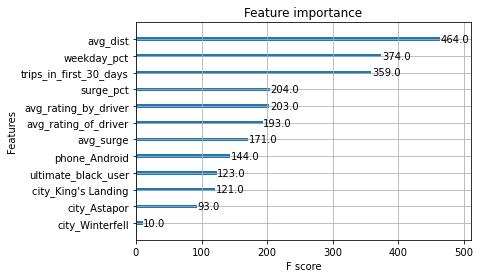

In [176]:
plot_importance(final_model)

The factors that most heavily influence rider retention are the __average distance in miles per trip taken in the first 30 days after signup__ and the __percent of the user's trips occuring during a weekday__. 